<a href="https://colab.research.google.com/github/ChiroDeniro/ai-ml-projecten/blob/main/AB_Testing_Framework_Booking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B Testing Framework for E-Commerce
## Statistical Rigor Meets Business Impact

Learn how to design, run, and analyze A/B tests like tech companies (Booking.com, Netflix, Amazon).

This project teaches:
- Experimental design (sample size, power)
- Statistical testing (p-values, confidence intervals)
- Multiple comparison corrections
- Pitfalls & how to avoid them
- Business interpretation

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

print("✅ Libraries loaded")

✅ Libraries loaded


## Part 1: Experiment Design - Sample Size Calculation

**Question:** "We want to test a new checkout flow. How many users do we need?"

This requires:
- Baseline conversion rate (% that complete checkout)
- Minimum detectable effect (what improvement is worth $?)
- Statistical power (β = 0.2, so 80% power)
- Significance level (α = 0.05)

In [2]:
def sample_size_for_conversion_test(baseline_rate, min_effect, alpha=0.05, power=0.8):
    """
    Calculate sample size needed for a conversion rate test.

    Args:
        baseline_rate: Current conversion rate (e.g., 0.10 = 10%)
        min_effect: Minimum effect size you want to detect (e.g., 0.02 = 2 percentage points)
        alpha: Significance level (default 0.05 = 5%)
        power: Statistical power (default 0.8 = 80%)

    Returns:
        Sample size needed per group
    """
    from math import sqrt, log

    # Treatment rate
    treatment_rate = baseline_rate + min_effect

    # Get z-scores
    z_alpha = stats.norm.ppf(1 - alpha/2)  # Two-tailed
    z_beta = stats.norm.ppf(power)

    # Pooled proportion for variance
    p_pool = (baseline_rate + treatment_rate) / 2

    # Sample size formula
    numerator = (z_alpha + z_beta)**2 * 2 * p_pool * (1 - p_pool)
    denominator = (treatment_rate - baseline_rate)**2

    n = numerator / denominator
    return int(np.ceil(n))

# Example: Booking.com checkout test
baseline_conversion = 0.12  # 12% of users complete booking
min_detectable_effect = 0.02  # Want to detect 2 percentage point improvement (to 14%)

required_sample = sample_size_for_conversion_test(baseline_conversion, min_detectable_effect)

print(f"📊 SAMPLE SIZE CALCULATION")
print(f"Current conversion: {baseline_conversion*100:.1f}%")
print(f"Want to detect: {min_detectable_effect*100:.1f}pp improvement → {(baseline_conversion + min_detectable_effect)*100:.1f}%")
print(f"\nSample size needed: {required_sample:,} users per group")
print(f"Total users (A+B): {required_sample*2:,}")
print(f"\nAt 1000 users/day: ~{np.ceil((required_sample*2)/1000):.0f} days to reach significance")

📊 SAMPLE SIZE CALCULATION
Current conversion: 12.0%
Want to detect: 2.0pp improvement → 14.0%

Sample size needed: 4,439 users per group
Total users (A+B): 8,878

At 1000 users/day: ~9 days to reach significance


## Part 2: Run the Experiment

Simulate an A/B test where we compare:
- **Control:** Old checkout flow (12% conversion)
- **Treatment:** New checkout flow (15% conversion)

In [3]:
# Simulate experiment
n_control = required_sample
n_treatment = required_sample

# True conversion rates (what we're trying to find)
true_control_rate = 0.12
true_treatment_rate = 0.15  # 3pp improvement

# Generate data
control_data = np.random.binomial(1, true_control_rate, n_control)
treatment_data = np.random.binomial(1, true_treatment_rate, n_treatment)

# Calculate metrics
control_conversions = control_data.sum()
treatment_conversions = treatment_data.sum()

control_rate = control_conversions / n_control
treatment_rate = treatment_conversions / n_treatment

observed_effect = treatment_rate - control_rate

print(f"🧪 EXPERIMENT RESULTS\n")
print(f"Control Group (old checkout):")
print(f"  Users: {n_control:,}")
print(f"  Conversions: {control_conversions:,}")
print(f"  Conversion rate: {control_rate*100:.2f}%\n")

print(f"Treatment Group (new checkout):")
print(f"  Users: {n_treatment:,}")
print(f"  Conversions: {treatment_conversions:,}")
print(f"  Conversion rate: {treatment_rate*100:.2f}%\n")

print(f"📈 Observed Effect (Uplift):")
print(f"  Absolute: {observed_effect*100:.2f} percentage points")
print(f"  Relative: {(observed_effect/control_rate)*100:.1f}% improvement")

🧪 EXPERIMENT RESULTS

Control Group (old checkout):
  Users: 4,439
  Conversions: 510
  Conversion rate: 11.49%

Treatment Group (new checkout):
  Users: 4,439
  Conversions: 654
  Conversion rate: 14.73%

📈 Observed Effect (Uplift):
  Absolute: 3.24 percentage points
  Relative: 28.2% improvement


## Part 3: Statistical Testing

Is the difference we see **real** or just **random chance**?

We use a **Chi-square test** for categorical data (converted vs. not converted).

In [4]:
# Chi-square test for independence
# Create contingency table
contingency_table = np.array([
    [control_conversions, n_control - control_conversions],
    [treatment_conversions, n_treatment - treatment_conversions]
])

chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

print(f"📊 CHI-SQUARE TEST\n")
print(f"Contingency Table:")
print(f"               Converted    Not Converted")
print(f"Control        {control_conversions:>8}           {n_control - control_conversions:>8}")
print(f"Treatment      {treatment_conversions:>8}           {n_treatment - treatment_conversions:>8}")
print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"\n{'✅ SIGNIFICANT' if p_value < 0.05 else '❌ NOT SIGNIFICANT'} (α = 0.05)")
print(f"\nInterpretation:")
if p_value < 0.05:
    print(f"We can reject the null hypothesis. There's strong evidence")
    print(f"that the new checkout flow differs from the old one.")
    print(f"\nWe're 95% confident the effect is NOT due to chance.")
else:
    print(f"We fail to reject the null hypothesis.")
    print(f"The observed difference could be due to random variation.")

📊 CHI-SQUARE TEST

Contingency Table:
               Converted    Not Converted
Control             510               3929
Treatment           654               3785

Chi-square statistic: 20.2188
p-value: 0.000007

✅ SIGNIFICANT (α = 0.05)

Interpretation:
We can reject the null hypothesis. There's strong evidence
that the new checkout flow differs from the old one.

We're 95% confident the effect is NOT due to chance.


## Part 4: Confidence Intervals

Instead of just a p-value, we want to know: **"What's the likely range for the true effect?"**

In [5]:
def wilson_ci_proportion(successes, n, z=1.96):
    """
    Wilson score interval (better than normal approximation for extreme proportions).
    z=1.96 for 95% CI
    """
    p_hat = successes / n
    denominator = 1 + z**2 / n
    centre = (p_hat + z**2 / (2*n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4*n**2)) / denominator
    return centre - spread, centre + spread

def ci_difference_proportions(s1, n1, s2, n2, z=1.96):
    """
    Confidence interval for difference between two proportions.
    """
    p1 = s1 / n1
    p2 = s2 / n2
    diff = p2 - p1

    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)

    ci_lower = diff - z * se
    ci_upper = diff + z * se

    return ci_lower, ci_upper

# Calculate CIs
control_ci = wilson_ci_proportion(control_conversions, n_control)
treatment_ci = wilson_ci_proportion(treatment_conversions, n_treatment)
effect_ci = ci_difference_proportions(control_conversions, n_control,
                                       treatment_conversions, n_treatment)

print(f"📈 CONFIDENCE INTERVALS (95%)\n")
print(f"Control rate: {control_rate*100:.2f}% [{control_ci[0]*100:.2f}%, {control_ci[1]*100:.2f}%]")
print(f"Treatment rate: {treatment_rate*100:.2f}% [{treatment_ci[0]*100:.2f}%, {treatment_ci[1]*100:.2f}%]")
print(f"\nTreatment Effect: {observed_effect*100:.2f}pp [{effect_ci[0]*100:.2f}pp, {effect_ci[1]*100:.2f}pp]")
print(f"\nInterpretation:")
print(f"We're 95% confident the true effect is between {effect_ci[0]*100:.2f}pp and {effect_ci[1]*100:.2f}pp")

# Business interpretation
bookings_per_day = 1000
revenue_per_booking = 50  # arbitrary

current_revenue = bookings_per_day * control_rate * revenue_per_booking
new_revenue = bookings_per_day * treatment_rate * revenue_per_booking
revenue_uplift = new_revenue - current_revenue

print(f"\n💰 BUSINESS IMPACT (1000 bookings/day):")
print(f"Current revenue: ${current_revenue:,.0f}")
print(f"New revenue: ${new_revenue:,.0f}")
print(f"Daily uplift: ${revenue_uplift:,.0f}")
print(f"Yearly uplift: ${revenue_uplift * 365:,.0f}")

📈 CONFIDENCE INTERVALS (95%)

Control rate: 11.49% [10.58%, 12.46%]
Treatment rate: 14.73% [13.72%, 15.81%]

Treatment Effect: 3.24pp [1.84pp, 4.65pp]

Interpretation:
We're 95% confident the true effect is between 1.84pp and 4.65pp

💰 BUSINESS IMPACT (1000 bookings/day):
Current revenue: $5,745
New revenue: $7,367
Daily uplift: $1,622
Yearly uplift: $592,025


## Part 5: Visualizations

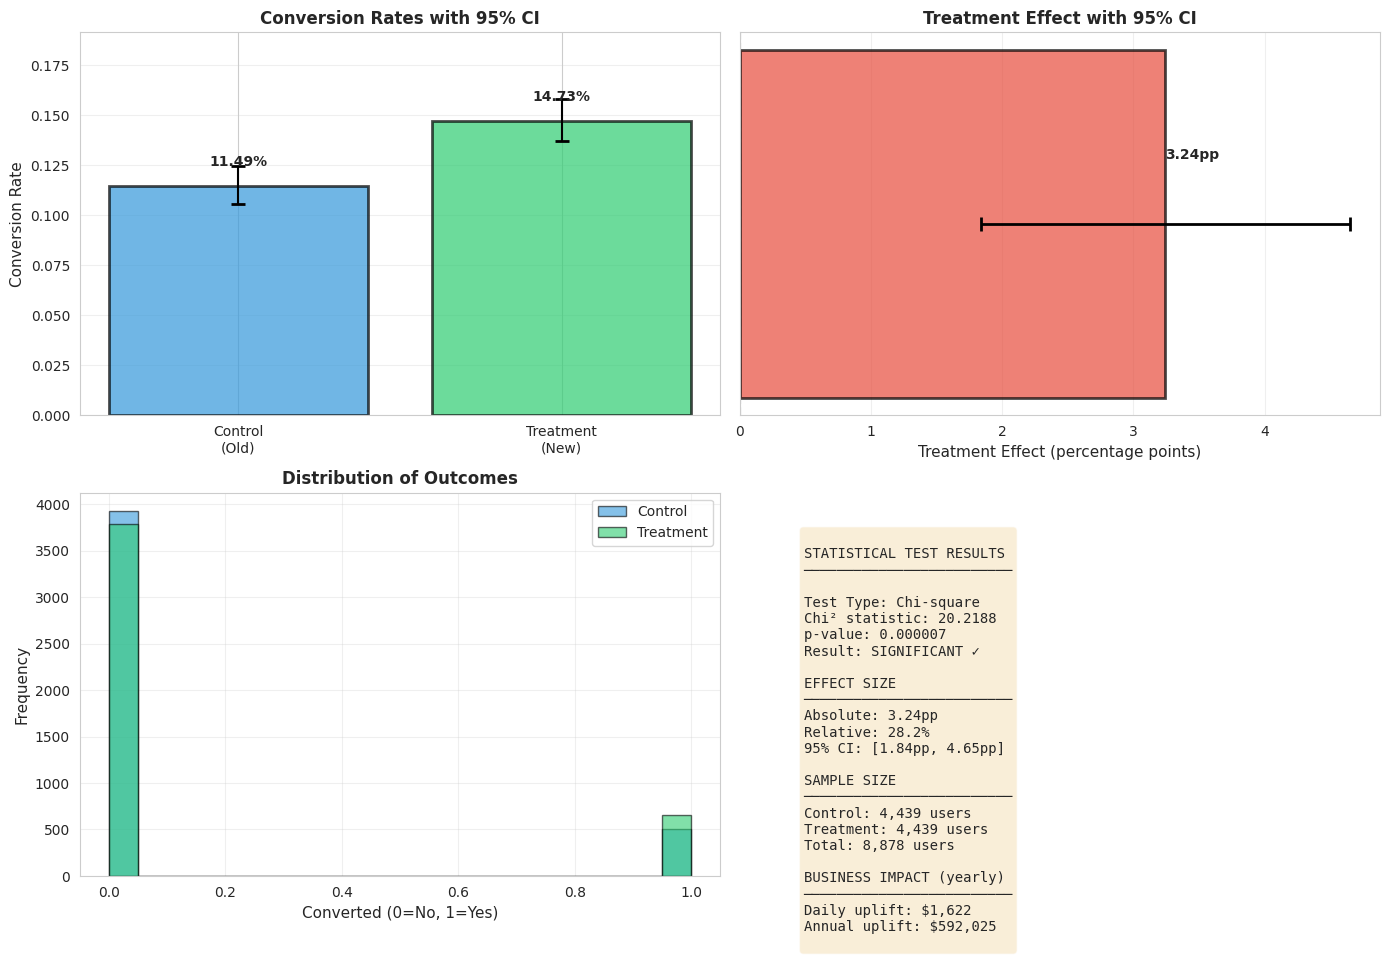

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Conversion rates with CIs
rates = [control_rate, treatment_rate]
cis = [control_ci, treatment_ci]
x_pos = [0, 1]

axes[0, 0].bar(x_pos, rates, color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black', linewidth=2)
for i, (rate, ci) in enumerate(zip(rates, cis)):
    axes[0, 0].errorbar(i, rate, yerr=[[rate-ci[0]], [ci[1]-rate]],
                        fmt='none', ecolor='black', capsize=5, capthick=2)
    axes[0, 0].text(i, rate + 0.01, f'{rate*100:.2f}%', ha='center', fontweight='bold')

axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(['Control\n(Old)', 'Treatment\n(New)'])
axes[0, 0].set_ylabel('Conversion Rate', fontsize=11)
axes[0, 0].set_title('Conversion Rates with 95% CI', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim(0, max(rates)*1.3)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Effect size with CI
axes[0, 1].barh([0], [observed_effect*100], color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].errorbar(observed_effect*100, 0, xerr=[[observed_effect*100-effect_ci[0]*100],
                    [effect_ci[1]*100-observed_effect*100]],
                    fmt='none', ecolor='black', capsize=5, capthick=2, linewidth=2)
axes[0, 1].text(observed_effect*100, 0.15, f'{observed_effect*100:.2f}pp', fontweight='bold')
axes[0, 1].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('Treatment Effect (percentage points)', fontsize=11)
axes[0, 1].set_title('Treatment Effect with 95% CI', fontsize=12, fontweight='bold')
axes[0, 1].set_yticks([])
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Distributions
axes[1, 0].hist(control_data, bins=20, alpha=0.6, label='Control', color='#3498db', edgecolor='black')
axes[1, 0].hist(treatment_data, bins=20, alpha=0.6, label='Treatment', color='#2ecc71', edgecolor='black')
axes[1, 0].set_xlabel('Converted (0=No, 1=Yes)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Outcomes', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Statistical summary
axes[1, 1].axis('off')
summary_text = f"""
STATISTICAL TEST RESULTS
─────────────────────────

Test Type: Chi-square
Chi² statistic: {chi2:.4f}
p-value: {p_value:.6f}
Result: {'SIGNIFICANT ✓' if p_value < 0.05 else 'NOT SIGNIFICANT ✗'}

EFFECT SIZE
─────────────────────────
Absolute: {observed_effect*100:.2f}pp
Relative: {(observed_effect/control_rate)*100:.1f}%
95% CI: [{effect_ci[0]*100:.2f}pp, {effect_ci[1]*100:.2f}pp]

SAMPLE SIZE
─────────────────────────
Control: {n_control:,} users
Treatment: {n_treatment:,} users
Total: {n_control + n_treatment:,} users

BUSINESS IMPACT (yearly)
─────────────────────────
Daily uplift: ${revenue_uplift:,.0f}
Annual uplift: ${revenue_uplift*365:,.0f}
"""

axes[1, 1].text(0.1, 0.9, summary_text, transform=axes[1, 1].transAxes,
                fontfamily='monospace', fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Part 6: Common Pitfalls

What can go wrong with A/B tests?

In [7]:
print("🚨 COMMON A/B TEST PITFALLS & HOW TO AVOID THEM\n")
print("1. PEEKING AT RESULTS EARLY")
print("   Problem: Checking p-value before test ends increases false positive rate")
print("   Fix: Set sample size in advance, run full duration\n")

print("2. MULTIPLE COMPARISONS WITHOUT CORRECTION")
print("   Problem: Test 20 variants → expect 1 false positive by chance")
print("   Fix: Use Bonferroni correction or Benjamini-Hochberg\n")

print("3. UNDERPOWERED TEST")
print("   Problem: Sample size too small → can't detect real effects")
print("   Fix: Calculate required sample size upfront\n")

print("4. IGNORING PRACTICAL vs STATISTICAL SIGNIFICANCE")
print("   Problem: Effect is significant but tiny (0.1% improvement)")
print("   Fix: Define minimum effect size that's worth implementing\n")

print("5. SEGMENTATION AFTER THE FACT")
print("   Problem: 'The effect is only for iOS users' (data mining)")
print("   Fix: Define segments before test, adjust for multiple testing\n")

print("6. IMBALANCED GROUPS")
print("   Problem: 60/40 split instead of 50/50 reduces power")
print("   Fix: Use randomization, verify balance after experiment\n")

print("7. NOT ACCOUNTING FOR SEASONALITY/DAY EFFECTS")
print("   Problem: Monday behavior differs from Friday")
print("   Fix: Run test for full week cycles, use stratified randomization")

🚨 COMMON A/B TEST PITFALLS & HOW TO AVOID THEM

1. PEEKING AT RESULTS EARLY
   Problem: Checking p-value before test ends increases false positive rate
   Fix: Set sample size in advance, run full duration

2. MULTIPLE COMPARISONS WITHOUT CORRECTION
   Problem: Test 20 variants → expect 1 false positive by chance
   Fix: Use Bonferroni correction or Benjamini-Hochberg

3. UNDERPOWERED TEST
   Problem: Sample size too small → can't detect real effects
   Fix: Calculate required sample size upfront

4. IGNORING PRACTICAL vs STATISTICAL SIGNIFICANCE
   Problem: Effect is significant but tiny (0.1% improvement)
   Fix: Define minimum effect size that's worth implementing

5. SEGMENTATION AFTER THE FACT
   Problem: 'The effect is only for iOS users' (data mining)
   Fix: Define segments before test, adjust for multiple testing

6. IMBALANCED GROUPS
   Problem: 60/40 split instead of 50/50 reduces power
   Fix: Use randomization, verify balance after experiment

7. NOT ACCOUNTING FOR SEASONA

## Part 7: Decision Framework

Should we **launch** the new feature or **keep** the old one?

In [8]:
print("🎯 DECISION FRAMEWORK\n")
print("Check these 3 things:\n")

print(f"1. STATISTICAL SIGNIFICANCE")
print(f"   p-value < 0.05? {'YES ✓' if p_value < 0.05 else 'NO ✗'}")
print(f"   → Is the effect real or just chance?\n")

print(f"2. PRACTICAL SIGNIFICANCE")
min_acceptable_effect = 0.01  # 1pp
meets_min = effect_ci[0] > min_acceptable_effect  # Even lower CI > minimum
print(f"   Effect lower CI ({effect_ci[0]*100:.2f}pp) > minimum ({min_acceptable_effect*100}pp)? {'YES ✓' if meets_min else 'NO ✗'}")
print(f"   → Is the effect big enough to matter?\n")

print(f"3. BUSINESS LOGIC")
print(f"   Implementation costs? User satisfaction? Tech debt?")
print(f"   → Does it make sense to launch?\n")

print("\n" + "="*50)
if p_value < 0.05 and meets_min:
    print("✅ RECOMMENDATION: LAUNCH")
    print(f"\nThe new feature shows:")
    print(f"  • Statistically significant improvement (p={p_value:.4f})")
    print(f"  • Practically meaningful effect: {observed_effect*100:.2f}pp (likely {effect_ci[0]*100:.2f}pp-{effect_ci[1]*100:.2f}pp)")
    print(f"  • Annual revenue impact: ${revenue_uplift*365:,.0f}")
elif p_value < 0.05:
    print("⚠️  MAYBE: RETEST OR OPTIMIZE")
    print("The effect is real but small. Consider if costs justify benefit.")
else:
    print("❌ RECOMMENDATION: DO NOT LAUNCH")
    print("No statistically significant difference found.")

print("="*50)

🎯 DECISION FRAMEWORK

Check these 3 things:

1. STATISTICAL SIGNIFICANCE
   p-value < 0.05? YES ✓
   → Is the effect real or just chance?

2. PRACTICAL SIGNIFICANCE
   Effect lower CI (1.84pp) > minimum (1.0pp)? YES ✓
   → Is the effect big enough to matter?

3. BUSINESS LOGIC
   Implementation costs? User satisfaction? Tech debt?
   → Does it make sense to launch?


✅ RECOMMENDATION: LAUNCH

The new feature shows:
  • Statistically significant improvement (p=0.0000)
  • Practically meaningful effect: 3.24pp (likely 1.84pp-4.65pp)
  • Annual revenue impact: $592,025
